## Пробуем обогатить датасет фичами, полученными с помощью DeepTMHMM 

DeepTMHMM позволяет предсказывать участки белков, которые являются трансмембранными (membrane), внутриклеточными (in_cell), внеклеточными (out_cell) или сигнальными пептидами (signal)
Проверим, насколько длина участков этих классов отличаются у CPPs и non-CPPs

In [2]:
!pip3 install -qU pybiolib

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:
import pandas as pd
import biolib

def create_fasta_file(dataframe, column_name, output_file):
    with open(output_file, 'w') as file:
        for index, sequence in dataframe[column_name].items():
            file.write(f">{index}\n{sequence}\n")

def create_deeptmhmm_files(fasta, resdir):
    deeptmhmm = biolib.load('DTU/DeepTMHMM')
    deeptmhmm_job = deeptmhmm.cli(args=f'--fasta {fasta}')
    deeptmhmm_job.save_files(resdir)

def file3line_to_dataframe(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = {'struct_type': [], 'sequence': [], 'raw_pred': []}
    block_length = 3

    for i in range(0, len(lines), block_length):
        if i + block_length <= len(lines):
            data['struct_type'].append(lines[i].strip().split('|')[-1].strip())
            data['sequence'].append(lines[i+1].strip())
            data['raw_pred'].append(lines[i+2].strip())

    df = pd.DataFrame(data)
    return df

def add_deeptmhmm(datafile, fastafile, resdir):
    initial_df = pd.read_csv(datafile)
    create_fasta_file(initial_df, column_name='sequence', output_file=fastafile)
    create_deeptmhmm_files(fastafile, resdir)
    
    file3line = './'+resdir+'/predicted_topologies.3line'
    new_df = file3line_to_dataframe(file_path=file3line)
    new_df = new_df.drop('sequence', axis =1)

    new_df['in_cell'] = new_df['raw_pred'].apply(lambda string: string.count('I'))
    new_df['out_cell'] = new_df['raw_pred'].apply(lambda string: string.count('O'))
    new_df['membrane'] = new_df['raw_pred'].apply(lambda string: string.count('M'))
    new_df['signal'] = new_df['raw_pred'].apply(lambda string: string.count('S'))
    new_df = new_df.drop('raw_pred', axis=1)

    return pd.concat([initial_df, new_df], axis=1)


In [5]:
#8 минут
test_df = add_deeptmhmm('binary_preprocessed.csv', 'testfasta.fasta','testdir')
test_df

2024-07-22 16:04:34,346 | INFO : Loaded project DTU/DeepTMHMM:1.0.39
2024-07-22 16:04:40,013 | INFO : Cloud: Initializing
2024-07-22 16:04:42,204 | INFO : Cloud: Pulling images...
2024-07-22 16:04:42,205 | INFO : Cloud: Computing...
2024-07-22 13:04:43,394 | INFO : Large input detected. Allocating dedicated capacity ...
Running DeepTMHMM on 3121 sequences...
Step 1/4 | Loading transformer model...

Step 2/4 | Generating embeddings for sequences...
Generating embeddings: 100% 3121/3121 [01:17<00:00, 40.37seq/s]

Step 3/4 | Predicting topologies for sequences in batches of 1...
Topology prediction: 100% 3121/3121 [02:33<00:00, 20.32seq/s]

Step 4/4 | Generating output...
2024-07-22 13:14:02,381 | INFO : Done in 559.36 seconds
2024-07-22 16:14:04,548 | INFO : Cloud: Computation finished
2024-07-22 16:14:04,551 | INFO : Cloud: Result Ready
2024-07-22 16:14:04,552 | INFO : Waiting for job a1632e06-3b39-43c0-954c-53176ea7c9e6 to finish...
2024-07-22 16:14:05,055 | INFO : Job a1632e06-3b39-43

,Unnamed: 0,uptake_type,sequence,biotin_o,struct_type,in_cell,out_cell,membrane,signal
0,0,0,GTRTDSREDEI,0,GLOB,11,0,0,0
1,1,0,VLPAWQGYHPM,0,GLOB,0,11,0,0
2,2,0,AQPLWGLLSFLPL,0,SP,0,1,0,12
3,3,0,LPLESGNCAPF,0,GLOB,0,11,0,0
4,4,0,LFWLGWLGML,0,GLOB,0,10,0,0
...,...,...,...,...,...,...,...,...,...
3116,1559,1,KRRIRRERNKMAAAKSRNRRRELTDTGC,0,GLOB,28,0,0,0
3117,1560,1,WLRRIKAWLRRIKALNRQLGVAA,0,GLOB,23,0,0,0
3118,1561,1,GRKKRRQRRRPP,0,GLOB,12,0,0,0
3119,1562,1,RRRRRRRRR,0,GLOB,0,9,0,0


In [41]:
test_df.to_csv('binary_deeptmhmm.csv')

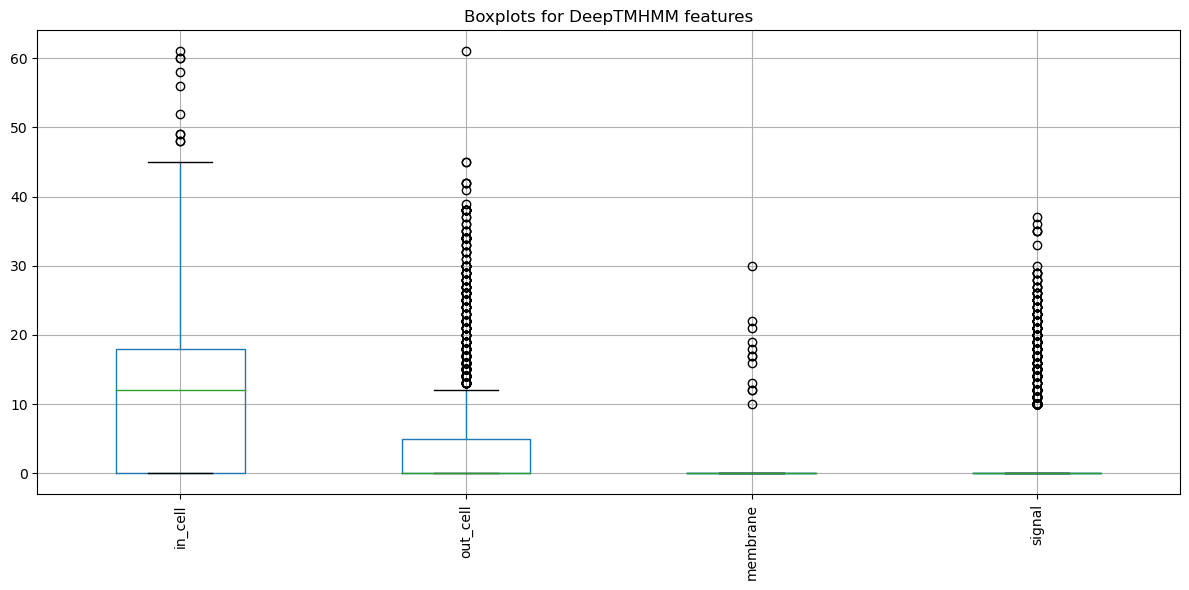

In [11]:
import matplotlib.pyplot as plt
def plot_boxplots(df):
    plt.figure(figsize=(12, 6))  # Устанавливаем размер графика
    df.boxplot()  # Строим боксплоты для всех столбцов датафрейма
    plt.xticks(rotation=90)  # Поворачиваем подписи по оси X, чтобы они не перекрывались
    plt.title('Boxplots for DeepTMHMM features')  # Устанавливаем заголовок графика
    plt.grid(True)  # Включаем сетку
    plt.tight_layout()  # Улучшаем отображение графика

    plt.show()  # Отображаем график
    
plot_boxplots(test_df.drop(['sequence', 'Unnamed: 0', 'uptake_type', 'biotin_o'], axis=1))

C:\Users\Макс\AppData\Local\Temp\ipykernel_17308\1038115905.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=test_df[test_df['uptake_type'] == 0]['out_cell'], shade=True)
C:\Users\Макс\AppData\Local\Temp\ipykernel_17308\1038115905.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=test_df[test_df['uptake_type'] == 1]['out_cell'], shade=True)


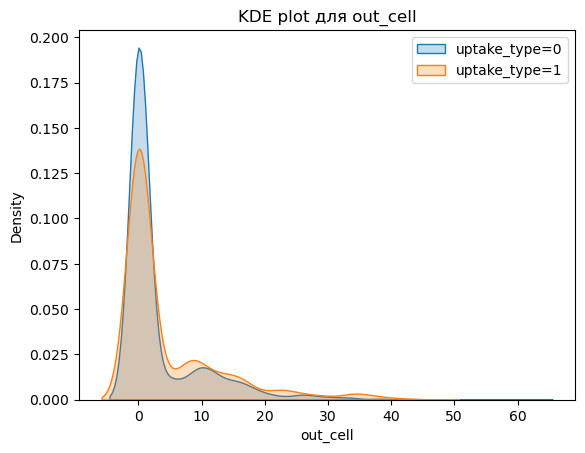

In [13]:
import seaborn as sns
sns.kdeplot(data=test_df[test_df['uptake_type'] == 0]['out_cell'], shade=True)
sns.kdeplot(data=test_df[test_df['uptake_type'] == 1]['out_cell'], shade=True)

# Настройка легенды и заголовка
plt.legend(['uptake_type=0', 'uptake_type=1'])
plt.title('KDE plot для out_cell')
plt.show()

C:\Users\Макс\AppData\Local\Temp\ipykernel_17308\3567843002.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=test_df[test_df['uptake_type'] == 0]['in_cell'], shade=True)
C:\Users\Макс\AppData\Local\Temp\ipykernel_17308\3567843002.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=test_df[test_df['uptake_type'] == 1]['in_cell'], shade=True)


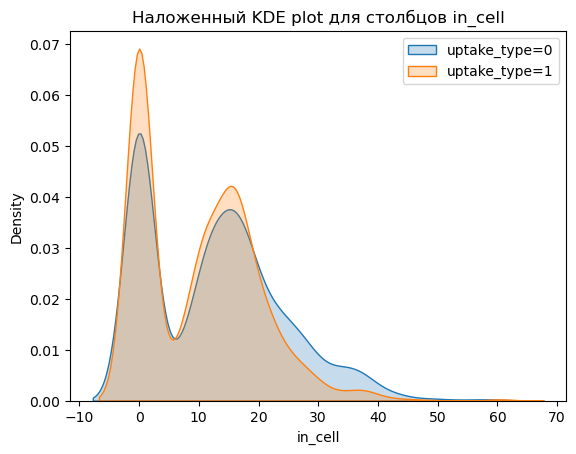

In [14]:
import seaborn as sns
sns.kdeplot(data=test_df[test_df['uptake_type'] == 0]['in_cell'], shade=True)
sns.kdeplot(data=test_df[test_df['uptake_type'] == 1]['in_cell'], shade=True)

# Настройка легенды и заголовка
plt.legend(['uptake_type=0', 'uptake_type=1'])
plt.title('Наложенный KDE plot для столбцов in_cell')
plt.show()

C:\Users\Макс\AppData\Local\Temp\ipykernel_17308\1400439310.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=test_df[test_df['uptake_type'] == 0]['signal'], shade=True)
C:\Users\Макс\AppData\Local\Temp\ipykernel_17308\1400439310.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=test_df[test_df['uptake_type'] == 1]['signal'], shade=True)


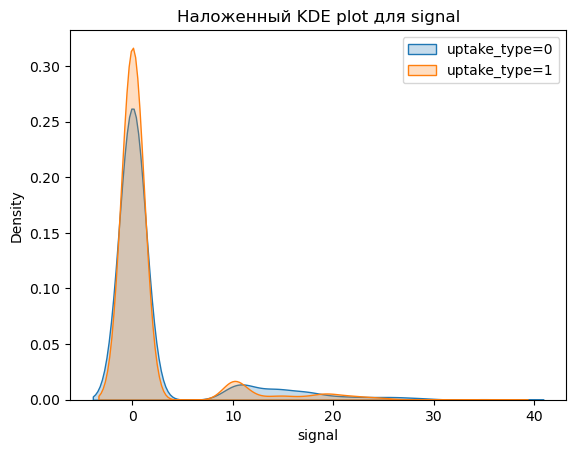

In [16]:
import seaborn as sns
sns.kdeplot(data=test_df[test_df['uptake_type'] == 0]['signal'], shade=True)
sns.kdeplot(data=test_df[test_df['uptake_type'] == 1]['signal'], shade=True)

# Настройка легенды и заголовка
plt.legend(['uptake_type=0', 'uptake_type=1'])
plt.title('Наложенный KDE plot для signal')
plt.show()

C:\Users\Макс\AppData\Local\Temp\ipykernel_17308\490143747.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=test_df[test_df['uptake_type'] == 0]['membrane'], shade=True)
C:\Users\Макс\AppData\Local\Temp\ipykernel_17308\490143747.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=test_df[test_df['uptake_type'] == 1]['membrane'], shade=True)


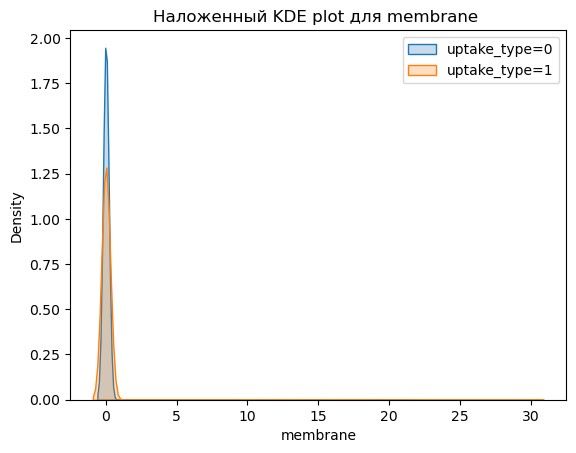

In [17]:
import seaborn as sns
sns.kdeplot(data=test_df[test_df['uptake_type'] == 0]['membrane'], shade=True)
sns.kdeplot(data=test_df[test_df['uptake_type'] == 1]['membrane'], shade=True)

# Настройка легенды и заголовка
plt.legend(['uptake_type=0', 'uptake_type=1'])
plt.title('Наложенный KDE plot для membrane ')
plt.show()

- на датасете для классификации распределения признаков, полученных с помощью DeepTMHMM для разных классов слишком сильно похожи, чтобы считать их важными 
- Возможно, такой результат был получен из-за того, что DeepTMHMM была натренирована на белках (как правило более 100 аминокислот), а пептиды в нашем датасете в основном длиной около 20 аминокислот